We downloaded the GloVe from their [github repo](https://github.com/stanfordnlp/GloVe) 

# Importing Libraries

In this section we import the libraries that we use

In [1]:
import numpy as np
import pandas as pd
import string



import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder




from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from gensim.models import word2vec


import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions We Use

In this section, we will put the functions that we are going to use in the next sections. The first two functions do some basic cleaning and the last function print the result of the models’ prediction.

In [3]:
def new_cleaning(data):


    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")
    
    
    return cleaned_data

In [4]:
def text_from_token(data):
    ## new_name   <----- "cleaned_text"
    
    cleaned_sentence = " ".join(data)
    
    return  cleaned_sentence

In [21]:
def print_results(model, X_train, y_train, X_test, y_test):
    
    le = LabelEncoder()
    le.fit_transform(y_train)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
    
    return report

# Importing Data

In [6]:
train = pd.read_csv("../Modeling/train_test/train.csv")
test  = pd.read_csv("../Modeling/train_test/test.csv")

train_test = [train, test] 

for df in train_test:
    
    df.drop("Unnamed: 0", inplace = True, axis = 1)

    df = pd.read_csv("../EDA/cleaned_all/cleaned_all.csv")

    df["cleaned"] =  df["cleaned"].apply(lambda x: new_cleaning(x))

    df["for_glove"] =  df["for_glove"].apply(lambda x: new_cleaning(x))

    df["cleaned_text"] = df["cleaned"].apply(lambda x: text_from_token(x))
    

print("DONE!")

DONE!


# Importing GloVe

In this section, we import the file that we downloaded from [Stanford NLP GitHub Repo](https://github.com/stanfordnlp/GloVe) to be used for our modeling

In [7]:
data = train["for_glove"].values
total_vocabulary = set(word for headline in data for word in headline)
len(total_vocabulary)


glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
            
            
print(f'There are {len(total_vocabulary)} unique tokens in the train dataset.') 
print("DONE!")   

There are 61 unique tokens in the train dataset.
DONE!


In [8]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this 
    # object implement a fit method or else it can't be used in a 
    # scikit-learn pipeline 
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])
    
    
    
print("DONE!") 

DONE!


In [9]:
train.columns

Index(['text', 'cleaned', 'for_glove', 'num_urls', 'neg', 'neu', 'pos',
       'compound', 'cleaned_text', 'label'],
      dtype='object')

# Train Test Split

In [28]:
X_train = train['for_glove'].values
y_train = train["label"]

X_test = test['for_glove'].values
y_test = test["label"]

# Pipelines

In this section, we will train different machine learning models on train set so that we could use them to filter out the fake news. The models we use are logistic regression, decision tree, random forest, xgboost and lightgbm. We will use the available word vectorized documents to train the model with on the training set in a pipeline and then we evaluate the performance of our model on the test sets.

## Making Pipelines

In [29]:
# LogisticRegression

col_transformer = ColumnTransformer(
transformers=[
("values", FunctionTransformer(values),"for_glove"),
("itself", FunctionTransformer(itself), ['neg', 'neu', 'pos', 
                                         'compound', 'num_urls'])
             ],    remainder="drop")



lr = Pipeline([
('Word2Vec Vectorizer', W2vVectorizer(glove)),
("Logistic Regression", LogisticRegression(class_weight="balanced",solver='liblinear',random_state=42))
              ])

# Decision Tree

tree = Pipeline([
('Word2Vec Vectorizer', W2vVectorizer(glove)),
("Decision Tree",DecisionTreeClassifier(class_weight="balanced",criterion ="gini",
                                  max_depth = 10, random_state = 42))    
                ])

# Random Forest

forest = Pipeline([
('Word2Vec Vectorizer', W2vVectorizer(glove)),
("Random Forest",RandomForestClassifier(criterion="entropy", n_estimators=20,
                            bootstrap = True, random_state = 42)) 
                 ])

# XGBoost

xgboost = Pipeline([
('Word2Vec Vectorizer', W2vVectorizer(glove)),
("xgb", xgb.XGBClassifier(max_depth=20,n_estimators=20,seed=42,
                  objective='binary:logistic', 
                          eval_metric = 'logloss'))
                  ])


# LightGBM
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
        'max_depth':20,
#         'eval_metric':"cross_entropy",
        'verbose':0,
        'random_seed': 42,
        'class_weight' :  'balanced',
        'force_row_wise' : True
          }

light = Pipeline([
('Word2Vec Vectorizer', W2vVectorizer(glove)),
("lgbm", lgb.LGBMClassifier(**params))
])
 

print("DONE!")

DONE!


## Models' Results

### Logistic Regression

The first model we train is logistic regression. By comparing this model with the one we trained on 1-gram TF-IDF, we conclude that the latter performs better in filtering out fake news.

Fitting is DONE!


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.60      0.80      0.70       0.70          0.72
      recall         0.75      0.66      0.70       0.71          0.70
      f1-score       0.66      0.73      0.70       0.69          0.70
      support     8719.00  13194.00      0.70   21913.00      21913.00
TRAIN precision      0.59      0.80      0.69       0.70          0.72
      recall         0.75      0.66      0.69       0.70          0.69
      f1-score       0.66      0.72      0.69       0.69          0.70
      support    17502.00  26987.00      0.69   44489.00      44489.00

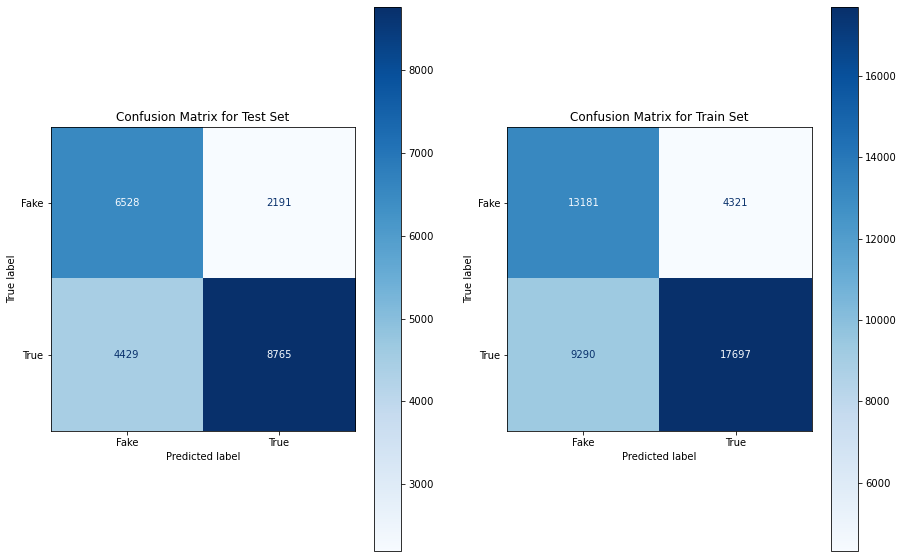

In [30]:
lr.fit(X_train, y_train)
print("Fitting is DONE!")

print_results(lr, X_train, y_train, X_test, y_test)

### Decision Tree

The second model that we train is decision tree. Compared to the logistic regression model that created in the previous subsection, we can see that the logistic regression model performs better in filtering out fake news because it has a better recall score, even though its accuracy is less than the current model. Also comparing to the model trained on 1-grams TF-IDF and 2-grams TF-IDF, we see that the current model performs poorly.  

Fitting is DONE!


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.63      0.77      0.71       0.70          0.71
      recall         0.67      0.74      0.71       0.70          0.71
      f1-score       0.65      0.75      0.71       0.70          0.71
      support     8719.00  13194.00      0.71   21913.00      21913.00
TRAIN precision      0.72      0.85      0.79       0.78          0.80
      recall         0.78      0.80      0.79       0.79          0.79
      f1-score       0.75      0.82      0.79       0.79          0.79
      support    17502.00  26987.00      0.79   44489.00      44489.00

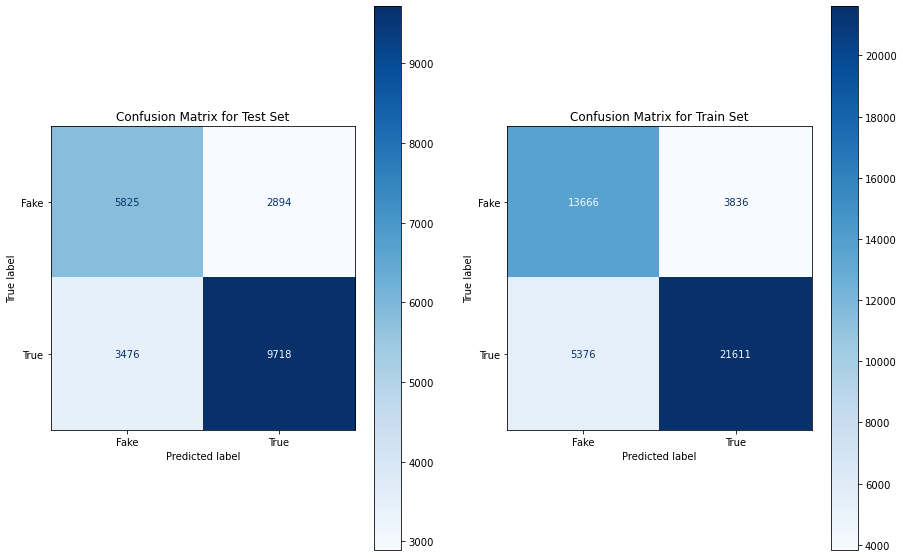

In [31]:
tree.fit(X_train, y_train)
print("Fitting is DONE!")

print_results(tree, X_train, y_train, X_test, y_test)

### Random Forest

The third model that we train is random forest and if we compare the results obtained from training this model with the two previous ones, we conclude that even though it has hight accuracy score, it does not perform better in filtering out the fake news. Moreover, by comparing the accuracy scores for test and train sets, we realize that this model is overfittedMoreover, we can see that this model does not out perform the random forest model when it was trained on 1-gram and 2-grams TF-IDF. Therefore, we put this model out.

Fitting is DONE!


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.74      0.77      0.76       0.76          0.76
      recall         0.60      0.86      0.76       0.73          0.76
      f1-score       0.67      0.81      0.76       0.74          0.75
      support     8719.00  13194.00      0.76   21913.00      21913.00
TRAIN precision      1.00      1.00      1.00       1.00          1.00
      recall         1.00      1.00      1.00       1.00          1.00
      f1-score       1.00      1.00      1.00       1.00          1.00
      support    17502.00  26987.00      1.00   44489.00      44489.00

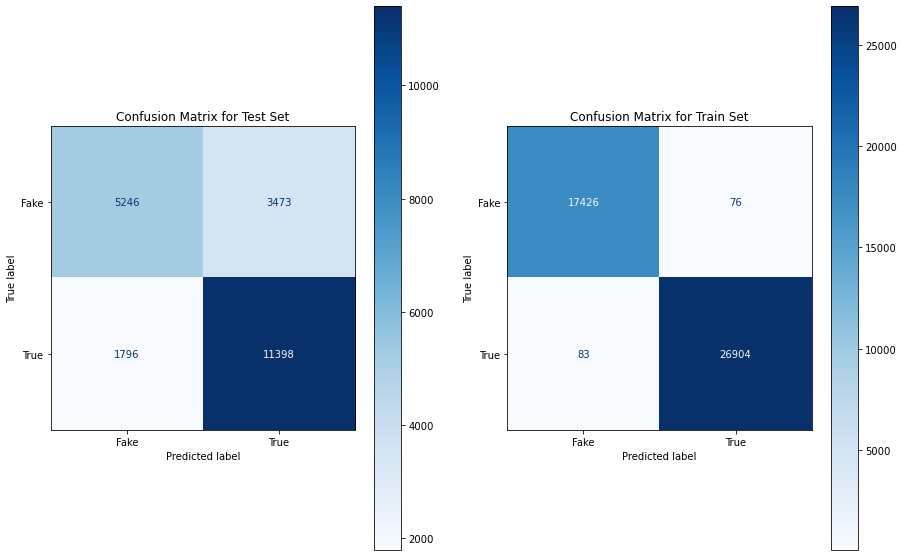

In [32]:
forest.fit(X_train, y_train)
print("Fitting is DONE!")

print_results(forest, X_train, y_train, X_test, y_test)

### XGBoost

The forth model that we train on the training set is xgboost model. By comparing the accuracy scores for test and train sets, we realize that this model is overfitted. On the other hand if we compare this model with the previous models in this notebook, we conclude that similar to the random forest model, it has lower recall score for fake news even though it has higher accuracy compared to the logistic regression model and decision tree.

Fitting is DONE!


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.76      0.77      0.76       0.76          0.76
      recall         0.60      0.87      0.76       0.74          0.76
      f1-score       0.67      0.82      0.76       0.74          0.76
      support     8719.00  13194.00      0.76   21913.00      21913.00
TRAIN precision      1.00      1.00      1.00       1.00          1.00
      recall         1.00      1.00      1.00       1.00          1.00
      f1-score       1.00      1.00      1.00       1.00          1.00
      support    17502.00  26987.00      1.00   44489.00      44489.00

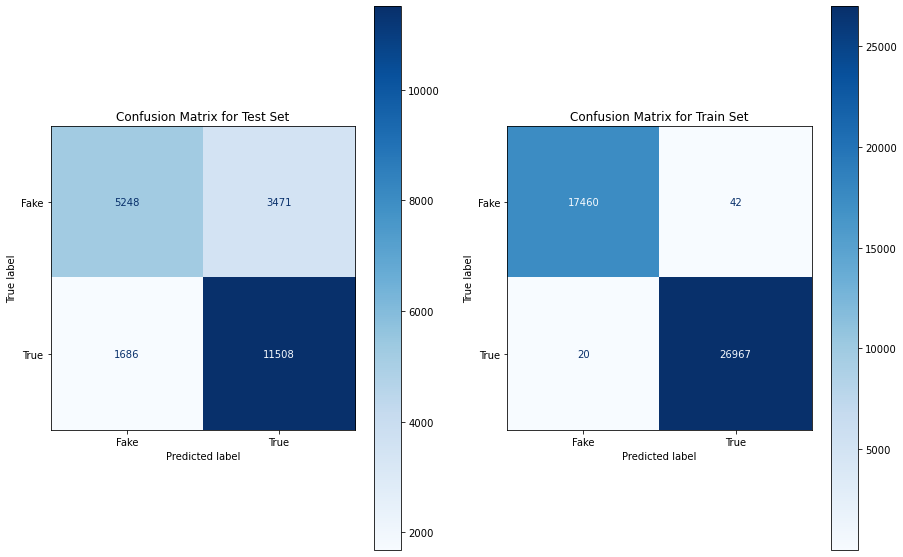

In [33]:
xgboost.fit(X_train, y_train)
print("Fitting is DONE!")

print_results(xgboost, X_train, y_train, X_test, y_test)

### LightGBM

We finish modeling in this notebook by training the LightGBM model on training sets. By comparing the result of this model with the previous models, we see that this model along with random forest and xgboost have the highest accuracy score. Moreover, this model does not show any signs of overfitting. Comparing to the model trained on 1-grams and 2-grams TF-IDF, we see that this model does not perform better. 

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fitting is DONE!


Fake      True  accuracy  macro avg  weighted avg
data  index                                                           
TEST  precision      0.72      0.78      0.76       0.75          0.76
      recall         0.64      0.84      0.76       0.74          0.76
      f1-score       0.68      0.81      0.76       0.74          0.76
      support     8719.00  13194.00      0.76   21913.00      21913.00
TRAIN precision      0.73      0.79      0.77       0.76          0.77
      recall         0.66      0.84      0.77       0.75          0.77
      f1-score       0.69      0.82      0.77       0.76          0.77
      support    17502.00  26987.00      0.77   44489.00      44489.00

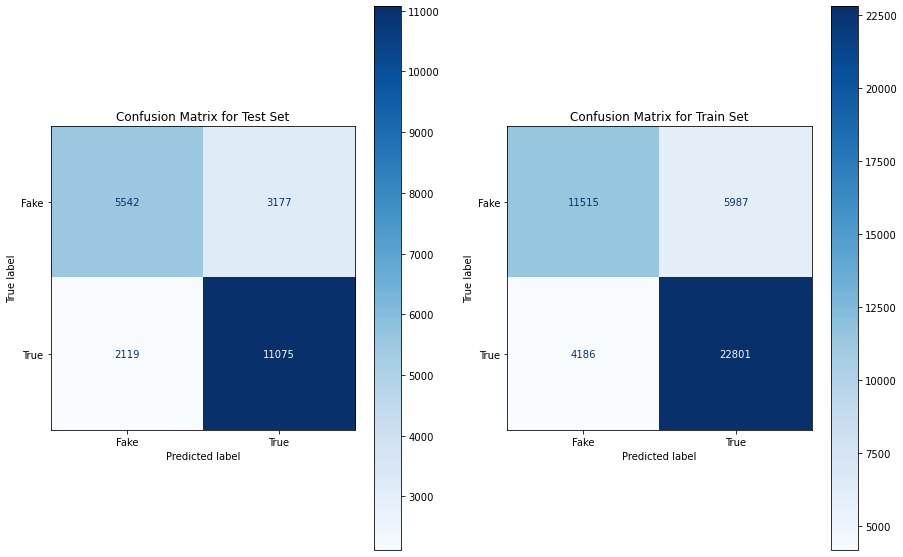

In [34]:
light.fit(X_train, y_train)
print("Fitting is DONE!")

print_results(light, X_train, y_train, X_test, y_test)

# Summary of Models

We realized that when different models are trained on data obtained from GloVE, they did not perform better compared to when they are trained on 1-grams and 2-grams TF-IDF. By comparing the different accuracy results, we see that LightGBM is not showing any signs of overfitting and it has the highest accuracy score. However, the recall scores obtained from using logistic regression model is better than the score we can get from LightGBM. Therefore, we would recommend logistic regression model as the final model of this notebook.

In order to improve the performances of these models we may use grid search to optimize their hyper-parameters. Moreover, if we try to extract and engineer more information from the texts, we may be able to improve these models.